# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# pip install pandas-profiling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Данные по региону 0

In [4]:
# посмотрим данные по региону 0

data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [5]:
data_0['id'].duplicated().sum()

10

### Данные по региону 1

In [6]:
# посмотрим данные по региону 1

data_1 = pd.read_csv('/datasets/geo_data_1.csv')


In [7]:
data_1['id'].duplicated().sum()

4

### Данные по региону 2

In [8]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')


In [9]:
data_2['id'].duplicated().sum()

4

Построим график распределения сырья по трем регионам.

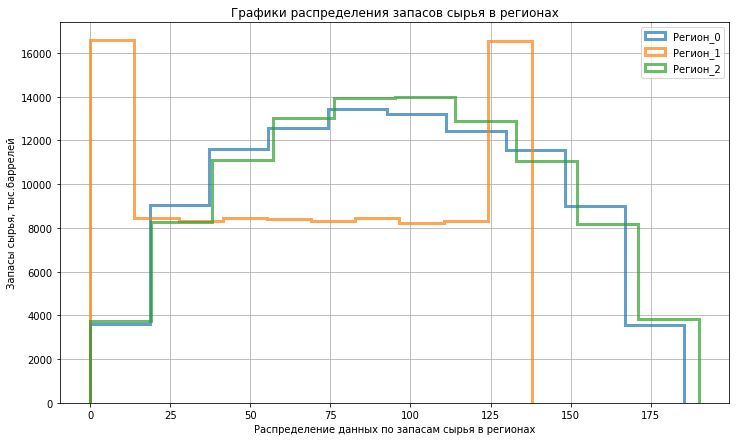

In [10]:
plt.title('Графики распределения запасов сырья в регионах')

ax=data_0['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=3, label='Регион_0')

ax1=data_1['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_1', ax=ax)

data_2['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_2', ax=ax1)

plt.xlabel('Распределение данных по запасам сырья в регионах')
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

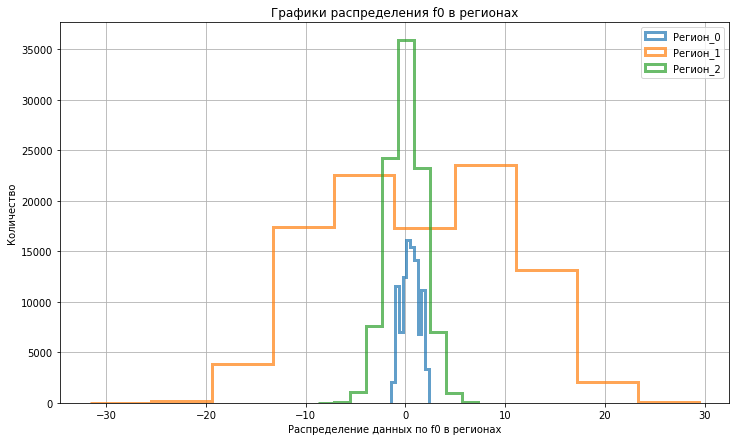

In [11]:
plt.title('Графики распределения f0 в регионах')

ax=data_0['f0'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=3, label='Регион_0')

ax1=data_1['f0'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_1', ax=ax)

data_2['f0'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_2', ax=ax1)

plt.xlabel('Распределение данных по f0 в регионах')
plt.ylabel('Количество')
plt.show()

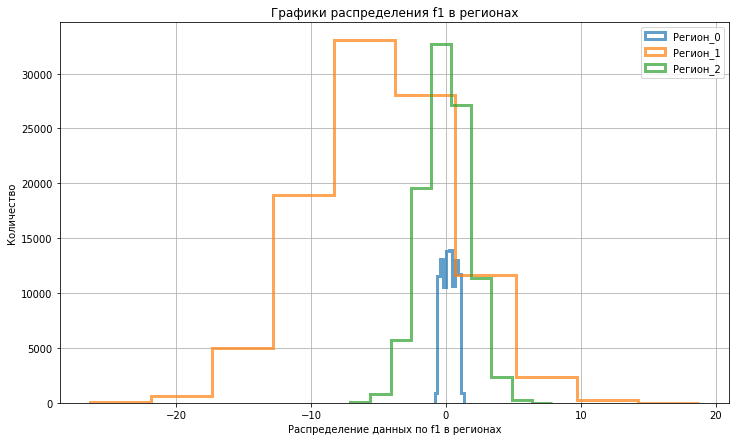

In [12]:
plt.title('Графики распределения f1 в регионах')

ax=data_0['f1'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=3, label='Регион_0')

ax1=data_1['f1'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_1', ax=ax)

data_2['f1'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_2', ax=ax1)

plt.xlabel('Распределение данных по f1 в регионах')
plt.ylabel('Количество')
plt.show()

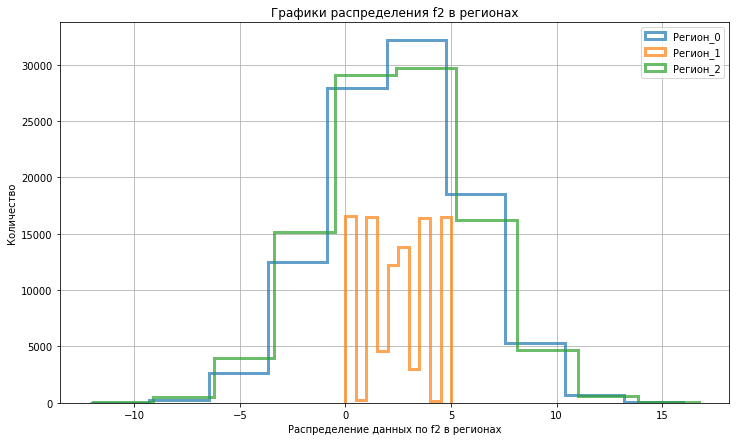

In [13]:
plt.title('Графики распределения f2 в регионах')

ax=data_0['f2'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=3, label='Регион_0')

ax1=data_1['f2'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_1', ax=ax)

data_2['f2'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='Регион_2', ax=ax1)

plt.xlabel('Распределение данных по f2 в регионах')
plt.ylabel('Количество')
plt.show()

In [14]:
data_1['f2'].describe()

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

### Выводы

- Нам даны три таблицы данных по 100 000 строк каждая. В них одинаковое число столбцов id, f0, f1, f2 и product.
- Типы данных соответствуют содержанию, пропусков и полных дубликатов нет.
- Есть дубликаты по id в каждом регионе, но не более 10 в каждом
- В Регионе 1 есть сильная корреляция между product и признаком f2
- В Регионе 1 признак f2 распределен не нормально

 <span style="color:blue"> Поменяла вывод </span>

## Обучение и проверка модели

Обучите и проверьте модель для каждого региона:
- Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучите модель и сделайте предсказания на валидационной выборке.
- Сохраните предсказания и правильные ответы на валидационной выборке.
- Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- Проанализируйте результаты.

In [15]:
def split_and_train(data):
    """
    Функция берет на вход датасет.
    
    Оставляет нужные признаки,
    Делит данные на train и valid  пропорции 75/25
    
    Обучает линейную модель
    
    Возвращает RMSE и предсказание средней добычи сырья по региону,
    предсказания и правильные ответы на валидационной выборке
    """
    
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    avg_prod = sum(predictions) / len(predictions)
    
    return (predictions, target_valid.reset_index(drop=True), round(avg_prod,2), round(rmse,2))

In [16]:
# Создадим словарь, чтобы потом наглядно вывести данные по каждому региону

data_reg = {'region': ['0', '1', '2'], 
            'avg_prod': [0,0,0],
             'RMSE': [0,0,0]
                       }

# Создадим массивы, где сохраним predictions, target_valid

predictions = [None]*3
target_valid = [None]*3

In [17]:
# Применим функцию split_and_train() к данным каждого региона, Выведем полученные аднные в таблицу
i = 0

for region in [data_0, data_1, data_2]:
    predictions[i], target_valid[i], data_reg['avg_prod'][i], data_reg['RMSE'][i] = split_and_train(region)
    i+=1
    
df_reg = pd.DataFrame(data_reg)    
df_reg.head()   

,region,avg_prod,RMSE
0,0,92.59,37.58
1,1,68.73,0.89
2,2,94.97,40.03


Мы получили значение RMSE сильно отличающееся в регионе 1. Это могло получиться с связи с тем, что в этом регионе запас продукта, например, сильно ниже, чем в других регионах. Для того, чтобы понять реальное соотношение RMSE, необходимо нормализовать его. Посчитать RMSE_norm = RMSE/max(data['product']) - min(data['product']).

Добавим этот столбец в нашу таблицу и сравним новые показатели.

In [18]:
i = 0
df_reg['RMSE_norm'] = [0.,0.,0.]

for region in [data_0, data_1, data_2]:
    df_reg['RMSE_norm'][i] = round(df_reg['RMSE'][i]/max(region['product']) - min(region['product']), 3)
    i+=1

df_reg.head() 

/tmp/ipykernel_160/3489309285.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['RMSE_norm'][i] = round(df_reg['RMSE'][i]/max(region['product']) - min(region['product']), 3)


,region,avg_prod,RMSE,RMSE_norm
0,0,92.59,37.58,0.203
1,1,68.73,0.89,0.006
2,2,94.97,40.03,0.211


Нормализация RMSE не привела к существенному изменению в разнице показателей. Это значит, что обученная модели лучше работает на данных из региона 1 и хуже, на данных регионов 0 и 2. Либо есть сильная корреляция между данными в регионе 1.

### Выводы

- Обучили модель LinearRegression на данных всех регионов
- Нашли предсказание средней выручки и среднеквадратичную ошибку RMSE на данных каждого региона

## Подготовка к расчёту прибыли

 Подготовьтесь к расчёту прибыли:
- Все ключевые значения для расчётов сохраните в отдельных переменных.
- Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
- Напишите выводы по этапу подготовки расчёта прибыли.

### Ключевые значения для расчётов

In [19]:
# количество точек для разработки - 200

WELL_COUNT = 200

# бюджет на разработку всех скважин в регионе 10 млрд

TOTAL_BUDGET = 10**10

# цена за 1000 баррелей нефти 450 тысяч

CPM_BARRELS = 450000

# вероятность убытков - 2.5%

LOSS_PROB = 0.025


###  Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе

In [20]:
# вычислим стоимость разработки одной скважины

WELL_BUDGET = TOTAL_BUDGET / WELL_COUNT

WELL_BUDGET

50000000.0

In [21]:
# вычислим необходимое число запасов сырья в тысячах баррелей для окупаемости разработки скважины

WELL_NEED_BARRELS = round(WELL_BUDGET / CPM_BARRELS, 2)
WELL_NEED_BARRELS

111.11

In [22]:
# сравним полученый показатель со средними показателями запасов в каждом регионе

# Создадим словарь, чтобы потом наглядно вывести данные по каждому региону

data_mean = {'region': ['0', '1', '2'], 
            'mean': [data_0['product'].mean(),data_1['product'].mean(),data_2['product'].mean()],
             'well_need_barrels': [WELL_NEED_BARRELS,WELL_NEED_BARRELS,WELL_NEED_BARRELS]
                       }
data_mean = pd.DataFrame(data_mean)    
data_mean.head()  

,region,mean,well_need_barrels
0,0,92.500,111.11
1,1,68.825,111.11
2,2,95.000,111.11


### Выводы

- Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Сравнили полученный объём сырья со средним запасом в каждом регионе.
- В каждом регионе среднего количества запасов сырья недостаточно для вывода всех скважин на уровень безубыточности. Необходимо выбрать самые прибыльные и оставить только их.

## Расчёт прибыли и рисков 

### Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

In [23]:
def profit_func(predictions, target,count):

    top_preds = pd.Series(predictions).sort_values(ascending=False)
    top_target = target[top_preds.index][:count]
    wells_revenue = top_target.sum() * CPM_BARRELS
    return wells_revenue - TOTAL_BUDGET


### Посчитайте риски и прибыль для каждого региона

- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [24]:
# код ревьюера
import numpy as np

In [25]:
# напишем функцию, рассчитывающую  среднюю прибыль, 95%-й доверительный интервал и риск убытков

state = np.random.RandomState(12345)

def profit_int_and_risk(predictions, target):
    profit = []
    predictions = pd.Series(predictions, index=target.index)
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit.append(profit_func(predictions_sample, target_sample, WELL_COUNT))
        
    profit = pd.Series(profit)
    mean = profit.mean()
    lower = profit.quantile(LOSS_PROB)
    higher = profit.quantile(1- LOSS_PROB)
    risk = profit[profit<0].mean()
    
    return  mean, lower, higher, risk, profit


In [26]:
# Создадим словарь, чтобы потом наглядно вывести данные по каждому региону

data_risk = {'region': ['0', '1', '2'], 
            'mean': [0.,0.,0.],
            'profit_from': [0.,0.,0.],
            'profit_to': [0.,0.,0.],
            'risk': [0.,0.,0.]
                              }
#data_risk = pd.DataFrame(data_risk)    

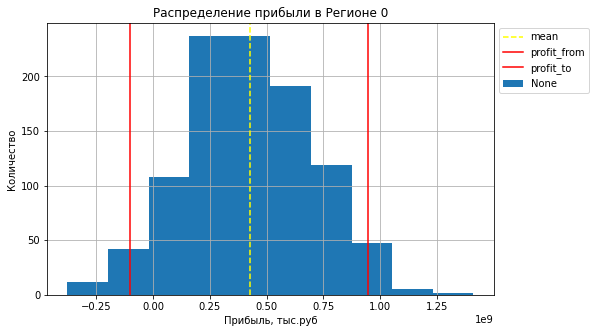

Средняя прибыль: 425938.53 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102090.09 млн.руб до: 947976.35 млн.руб
Процент вероятности убытка в данном регионе составит -11491482954.7%


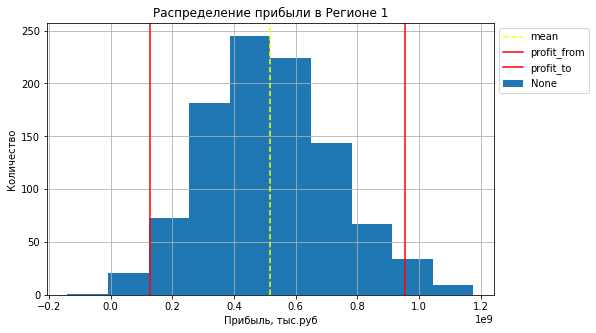

Средняя прибыль: 518259.49 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 128123.23 млн.руб до: 953612.98 млн.руб
Процент вероятности убытка в данном регионе составит -4908409321.0%


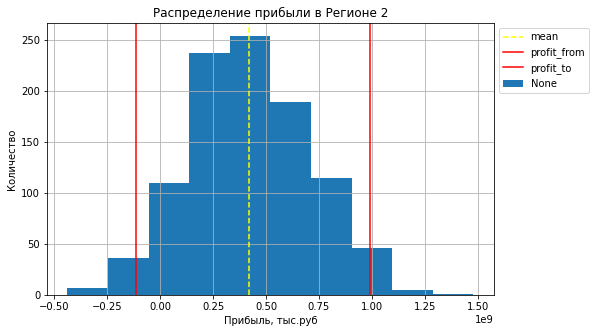

Средняя прибыль: 420194.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -115852.61 млн.руб до: 989629.94 млн.руб
Процент вероятности убытка в данном регионе составит -12137180853.1%


In [27]:
# Применим функцию profit_int_and_risk() к данным каждого региона, выведем полученные аднные в таблицу
i = 0

for i in range(0,3):
    data_risk['mean'][i], data_risk['profit_from'][i], data_risk['profit_to'][i], data_risk['risk'][i], profit = \
    profit_int_and_risk(predictions[i], target_valid[i])
    
    s = 'Распределение прибыли в Регионе ' + str(i)
    plt.title(s)
    profit.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')

    plt.axvline(x=data_risk['mean'][i], color='yellow', ls='--', label='mean')
    plt.axvline(x=data_risk['profit_from'][i], color='red', label= 'profit_from')
    plt.axvline(x=data_risk['profit_to'][i], color='red', label= 'profit_to')
    
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

    plt.show()
    
    
    print("Средняя прибыль: {:.2f} млн.руб".format(data_risk['mean'][i]/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((data_risk['profit_from'][i]/1000),(data_risk['profit_to'][i]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(data_risk['risk'][i]))

Выведем данные в таблице.

In [30]:
df_risk = pd.DataFrame(data_risk)    
df_risk.head()

,region,mean,profit_from,profit_to,risk
0,0,4.259385e+08,-1.020901e+08,9.479764e+08,-1.149148e+08
1,1,5.182595e+08,1.281232e+08,9.536130e+08,-4.908409e+07
2,2,4.201940e+08,-1.158526e+08,9.896299e+08,-1.213718e+08


In [31]:
for reg, m, pf, pt, r in zip(data_risk['region'], data_risk['mean'], data_risk['profit_from'], data_risk['profit_to'], data_risk['risk']):
      
    print(f'Средняя прибыль в Регионе {reg}: {m/1000:.2f} млн.руб')
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((pf/1000),(pt/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(r))
    print()

Средняя прибыль в Регионе 0: 425938.53 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102090.09 млн.руб до: 947976.35 млн.руб
Процент вероятности убытка в данном регионе составит -11491482954.7%

Средняя прибыль в Регионе 1: 518259.49 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 128123.23 млн.руб до: 953612.98 млн.руб
Процент вероятности убытка в данном регионе составит -4908409321.0%

Средняя прибыль в Регионе 2: 420194.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -115852.61 млн.руб до: 989629.94 млн.руб
Процент вероятности убытка в данном регионе составит -12137180853.1%



### Выводы

- Оптимальным регионом для разработки оказался Регион 1. 
- Средняя предсказанная прибыль у него самая большая и равна 506133.45 млн.руб.
- Процент вероятности убытка в данном регионе составит 1.3%. Это меньше 2.5% по условию исследования.

## Общий вывод

- Нам даны три таблицы данных по 100 000 строк каждая. В них одинаковое число столбцов id, f0, f1, f2 и product.
- Типы данных соответствуют содержанию, пропусков и полных дубликатов нет.
- Есть дубликаты по id в каждом регионе, но не более 10 в каждом
- В Регионе 1 есть сильная корреляция между product и признаком f2
- В Регионе 1 признак f2 распределен не нормально

- Обучили модель LinearRegression на данных всех регионов.
- Нашли предсказание средней выручки и среднеквадратичную ошибку RMSE на данных каждого региона.

In [32]:
df_reg.head()

,region,avg_prod,RMSE,RMSE_norm
0,0,92.59,37.58,0.203
1,1,68.73,0.89,0.006
2,2,94.97,40.03,0.211


- Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Сравнили полученный объём сырья со средним запасом в каждом регионе.
- В каждом регионе среднего количества запасов сырья недостаточно для вывода всех скважин на уровень безубыточности. Необходимо выбрать самые прибыльные и оставить только их.

- Оптимальным регионом для разработки оказался Регион 1.
- Средняя предсказанная прибыль у него самая большая и равна 506133.45 млн.руб.
- Процент вероятности убытка в данном регионе составит 1.3%. Это меньше 2.5% по условию исследования.